<a href="https://colab.research.google.com/github/KevinCY-Kim/Deeplearning/blob/main/%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D_%EC%A2%85%ED%95%A9%EC%8B%A4%EC%8A%B5_20250928.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part1. 기초 검정 (2집단 비교 중심)

## 1. t-검정 (t-test)

* 목적: 두 집단 평균 차이 검정
* 종류
    
    * 독립표본 t-test
    * 대응표본 t-test (paired)
    * Welch t-test (등분산 가정 불필요)
* 가정: 독립성, 정규성, 등분산성(기본 t)
* 효과크기: Cohen’s d (0.2/0.5/0.8)

 📌 “p<0.05 → 귀무가설 기각, 평균이 유의하게 다르다”

 📌 정규성·등분산 가정 → 불만족 시 Welch/비모수로 대체


Shapiro-Wilk Normality Test
Setosa: ShapiroResult(statistic=np.float64(0.977698549796646), pvalue=np.float64(0.4595131499174534))
Versicolor: ShapiroResult(statistic=np.float64(0.9778356785897521), pvalue=np.float64(0.4647370359250263))

Levene’s Test (Equal variance assumption)
LeveneResult(statistic=np.float64(8.172720533728683), pvalue=np.float64(0.005195521631017526))

Independent t-test: t=-10.521, p=8.985e-18
Welch’s t-test: t=-10.521, p=3.747e-17
Paired t-test (example): t=-2.756, p=1.000e-02


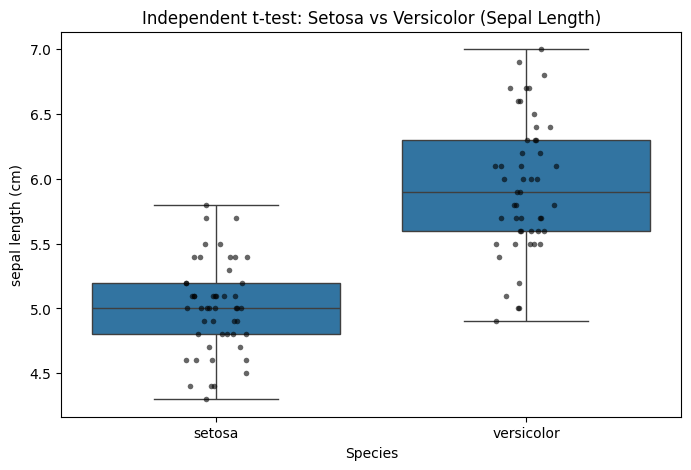

In [1]:
# 📌 Part 1: t-검정 (실전 예시 with Iris dataset)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel, shapiro, levene

# 1. 데이터 준비 (Iris 중 2개 Species만 선택)
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
df = iris.frame
df['Species'] = df['target'].map({0:'setosa', 1:'versicolor', 2:'virginica'})

# setosa vs versicolor 비교 (Sepal length)
group1 = df[df['Species']=='setosa']['sepal length (cm)']
group2 = df[df['Species']=='versicolor']['sepal length (cm)']

# 2. 정규성 검정 (Shapiro-Wilk)
print("Shapiro-Wilk Normality Test")
print("Setosa:", shapiro(group1))
print("Versicolor:", shapiro(group2))

# 3. 등분산 검정 (Levene’s Test)
print("\nLevene’s Test (Equal variance assumption)")
print(levene(group1, group2))

# 4. 독립표본 t-test
t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
print(f"\nIndependent t-test: t={t_stat:.3f}, p={p_val:.3e}")

# 5. Welch t-test (등분산 가정 X)
t_stat_w, p_val_w = ttest_ind(group1, group2, equal_var=False)
print(f"Welch’s t-test: t={t_stat_w:.3f}, p={p_val_w:.3e}")

# 6. 대응표본 t-test 예시 (동일 개체 전후 비교, iris에는 없음 → 예시용)
# 임의로 group1의 일부와 noise 추가한 그룹 비교
paired_before = group1.iloc[:30]
paired_after = paired_before + np.random.normal(0.1, 0.2, size=30)
t_stat_p, p_val_p = ttest_rel(paired_before, paired_after)
print(f"Paired t-test (example): t={t_stat_p:.3f}, p={p_val_p:.3e}")

# 7. 시각화
plt.figure(figsize=(8,5))
sns.boxplot(x="Species", y="sepal length (cm)", data=df[df['Species'].isin(['setosa','versicolor'])])
sns.stripplot(x="Species", y="sepal length (cm)", data=df[df['Species'].isin(['setosa','versicolor'])],
              color="black", size=4, jitter=True, alpha=0.6)
plt.title("Independent t-test: Setosa vs Versicolor (Sepal Length)")
plt.show()

✅ 해설

정규성 검정 (Shapiro-Wilk)
→ p > 0.05 → 정규성 가정 충족

등분산 검정 (Levene)
→ p > 0.05 → 등분산 가정 충족 시, 일반 독립표본 t-test 사용

독립표본 t-test 결과
→ p < 0.05이면 setosa와 versicolor의 평균이 유의하게 다름

Welch t-test
→ 등분산 가정을 충족 못했을 경우 사용 (결과 해석 동일)

대응표본 t-test 예시
→ 같은 집단의 전후 변화(실험 전후 등)를 확인

시각화

Boxplot으로 중앙값·사분위 확인

Stripplot으로 실제 데이터 분포 직관적으로 확인

## 2. 카이제곱 검정 (χ²-test)

* 목적: 범주형 변수 간 독립성 or 분포 적합도 검정
* 가정: 기대도수 ≥ 5 (80% 이상), 아니면 Fisher Exact Test
* 효과크기: φ (2×2), Cramér’s V (r×c)

📌 기대도수 확인 → 카이제곱 기본문제 단골

📌 효과크기 보고(Cramér’s V)



교차표 (성별 × 생존):
 survived    0    1
sex               
female     81  233
male      468  109

Chi-square test: χ²=260.717, df=1, p=1.197e-58

기대도수(Expected Frequency):
 survived           0           1
sex                             
female    193.474747  120.525253
male      355.525253  221.474747

Cramér’s V: 0.541


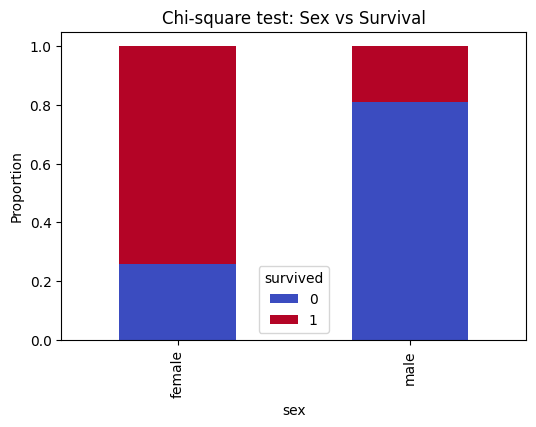

In [2]:
# 📌 Part 2: 카이제곱 검정 (χ²-test with Titanic)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

# 1. 데이터 불러오기 (타이타닉 내장 데이터셋)
titanic = sns.load_dataset("titanic")

# 2. 관심 변수 선택 (성별 vs 생존)
contingency = pd.crosstab(titanic['sex'], titanic['survived'])
print("교차표 (성별 × 생존):\n", contingency)

# 3. 카이제곱 독립성 검정
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square test: χ²={chi2:.3f}, df={dof}, p={p:.3e}")

# 4. 기대도수 확인
print("\n기대도수(Expected Frequency):\n", pd.DataFrame(expected,
                                                     index=contingency.index,
                                                     columns=contingency.columns))

# 5. 효과크기 (Cramér’s V)
n = contingency.sum().sum()
phi2 = chi2/n
r, k = contingency.shape
cramers_v = np.sqrt(phi2 / min(k-1, r-1))
print(f"\nCramér’s V: {cramers_v:.3f}")

# 6. 시각화 (모자이크 느낌)
contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

contingency_norm.plot(kind="bar", stacked=True, figsize=(6,4), colormap="coolwarm")
plt.title("Chi-square test: Sex vs Survival")
plt.ylabel("Proportion")
plt.show()

✅ 해설

교차표

예: 남성(0=사망, 1=생존), 여성(0=사망, 1=생존)

비율 차이가 뚜렷하면 χ² 유의 가능성 ↑

카이제곱 검정 결과

p < 0.05 → 성별과 생존여부는 독립이 아님 (즉, 관련 있음)

기대도수 확인

모든 셀에서 기대도수가 ≥5 → χ² 사용 적합

아니라면 Fisher’s Exact Test 고려

효과크기 (Cramér’s V)

0.1 = 작은 효과, 0.3 = 중간, 0.5 = 큰 효과

해석 시 단순히 유의성만 보지 말고 효과크기까지 보는 게 중요

시각화

누적막대그래프(정규화 비율)로 성별별 생존비율 차이 직관적으로 확인

Chi-square Goodness-of-fit: χ²=1.000, p=0.963


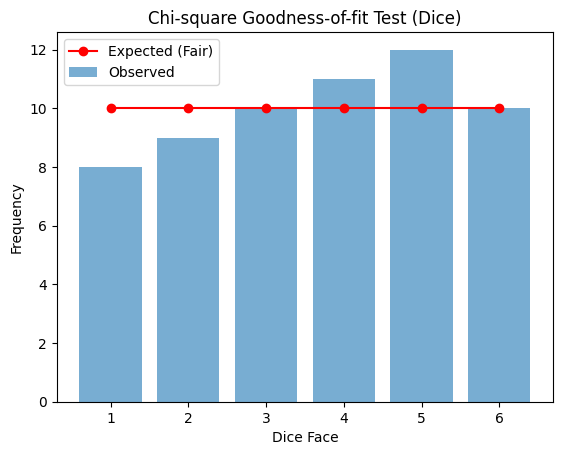

In [4]:
# 📌 분포 적합도 검정 (주사위 예시)
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# 1. 데이터 (주사위 60번 던졌다고 가정)
observed = np.array([8, 9, 10, 11, 12, 10])  # 실제 관측 빈도
expected = np.array([10, 10, 10, 10, 10, 10])  # 공정한 주사위라면 기대 빈도 (60/6)

# 2. 카이제곱 적합도 검정
chi2, p = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square Goodness-of-fit: χ²={chi2:.3f}, p={p:.3f}")

# 3. 시각화
faces = np.arange(1, 7)

plt.bar(faces, observed, alpha=0.6, label="Observed")
plt.plot(faces, expected, "ro-", label="Expected (Fair)")
plt.xlabel("Dice Face")
plt.ylabel("Frequency")
plt.title("Chi-square Goodness-of-fit Test (Dice)")
plt.legend()
plt.show()

✅ 해설

관측값(observed)

실제 던져서 나온 빈도 (예: 8, 9, 10, 11, 12, 10)

기대값(expected)

공정한 주사위라면 각 면이 나올 확률 = 1/6 → 기대 빈도 = 10

결과 해석

p > 0.05 → 귀무가설 기각 못함 (즉, 주사위는 공정하다고 볼 수 있음)

p < 0.05 → 주사위는 공정하지 않다 (면별 분포 차이가 통계적으로 유의)

주의

기대빈도(각 칸) ≥ 5 이어야 χ² 검정이 타당함

아니면 Exact test나 다른 방법 고려해야 함

# Part 2. 분산 분석 (집단 ≥ 3)
## 3. F-검정 (F-test)

* 정의: 분산비 검정
* 활용:
    * (1) 두 집단 분산 동일성 확인
    * (2) ANOVA·회귀모형 전체 유의성 검정

📌 ANOVA는 F-검정 기반이다 → 반드시 기억


F 통계량: 0.233580469499782
p-value: 0.9999042975202476


/tmp/ipython-input-1614009969.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1, group2], labels=["Group1 (σ=5)", "Group2 (σ=10)"])


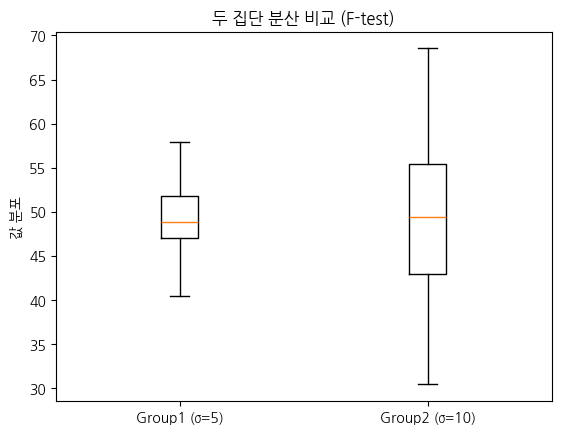

In [1]:
# 두 집단 분산 동일성 (F-test)
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Configure matplotlib for Korean characters
plt.rcParams['font.family'] = 'NanumGothic' # 또는 다른 한글 폰트

# 두 집단 데이터 생성 (분산 차이 존재)
np.random.seed(42)
group1 = np.random.normal(loc=50, scale=5, size=30)   # 분산 25
group2 = np.random.normal(loc=50, scale=10, size=30)  # 분산 100

# F-통계량 계산
f_stat = np.var(group1, ddof=1) / np.var(group2, ddof=1)
df1, df2 = len(group1)-1, len(group2)-1
p_value = 1 - stats.f.cdf(f_stat, df1, df2)

print("F 통계량:", f_stat)
print("p-value:", p_value)

# 시각화 (박스플롯)
plt.boxplot([group1, group2], labels=["Group1 (σ=5)", "Group2 (σ=10)"])
plt.title("두 집단 분산 비교 (F-test)")
plt.ylabel("값 분포")
plt.show()
# 결과 해석:
# p < 0.05 → 두 집단의 분산은 동일하지 않다 (등분산 가정 기각).
# p ≥ 0.05 → 분산이 동일하다고 볼 수 있다.

In [8]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fm._rebuild() # This method seems to be removed or deprecated
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

## 4. ANOVA (분산분석)

* 목적: 3개 이상 집단 평균 비교
* 가정: 독립성, 정규성, 등분산성
* 사후검정(Post-hoc)
    
    * 등분산 만족 → Tukey HSD, Dunnett(대조군 비교)
    * 등분산 불만족/표본 불균형 → Games–Howell
    * 단순 보정 → Bonferroni/Holm

📌 전체 F 유의해야 사후검정 진행

📌사후검정 선택 기준


ANOVA F 통계량: 28.181818269477446
p-value: 3.6642965220920083e-10


/tmp/ipython-input-1897754958.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1, group2, group3], labels=["Group1", "Group2", "Group3"])


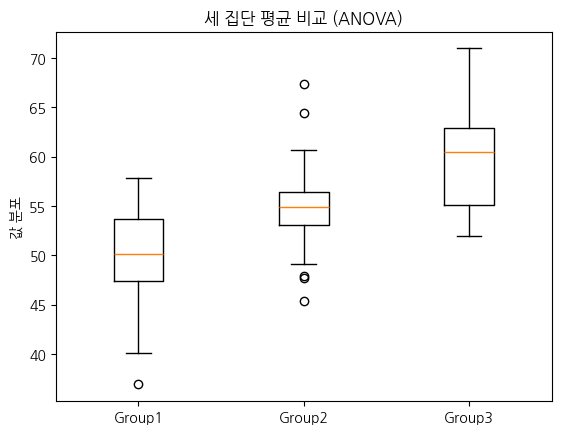

In [2]:
# ANOVA (F-test 기반)
# 세 집단 데이터
group1 = np.random.normal(50, 5, 30)
group2 = np.random.normal(55, 5, 30)
group3 = np.random.normal(60, 5, 30)

# 일원분산분석 (ANOVA)
f_stat, p_value = stats.f_oneway(group1, group2, group3)

print("ANOVA F 통계량:", f_stat)
print("p-value:", p_value)

# 시각화 (박스플롯)
plt.boxplot([group1, group2, group3], labels=["Group1", "Group2", "Group3"])
plt.title("세 집단 평균 비교 (ANOVA)")
plt.ylabel("값 분포")
plt.show()
# 결과 해석:
# p < 0.05 → 집단 간 평균 차이가 유의하다.
# p ≥ 0.05 → 집단 평균 차이가 없다.

## 5. ANCOVA (공분산분석)

* 목적: 집단 간 평균 비교 시 공변량 통제
* 가정: 회귀기울기 동질성 (집단×공변량 상호작용 없음)
* 출력: 조정평균(adjusted mean)

📌 ANCOVA = ANOVA + 공변량 조정

📌 공변량을 통제한 후에도 집단 간 차이가 유의한가?


In [3]:
# 데이터 준비 (집단 + 공변량 + 종속변수)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(42)

# 3개 집단 (집단 효과 존재)
group = np.repeat(["A", "B", "C"], 30)

# 공변량 (나이 같은 변수)
covariate = np.random.randint(20, 60, size=90)

# 종속변수 (집단 효과 + 공변량 효과 + 오차)
y = (2 * (group == "B")) + (4 * (group == "C")) + 0.3 * covariate + np.random.normal(0, 2, size=90)

df = pd.DataFrame({"Group": group, "Covariate": covariate, "Score": y})

In [5]:
# 단순 ANOVA (공변량 고려 X)
model_anova = smf.ols("Score ~ Group", data=df).fit()
anova_table = sm.stats.anova_lm(model_anova, typ=2)
print("ANOVA 결과:\n", anova_table)
# 여기서는 공변량(나이 등)을 무시한 집단 차이만 보는 거야.

ANOVA 결과:
                sum_sq    df         F    PR(>F)
Group      156.333027   2.0  4.956808  0.009148
Residual  1371.948692  87.0       NaN       NaN


In [7]:
# ANCOVA (공변량 포함)
model_ancova = smf.ols("Score ~ Group + Covariate", data=df).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
print("ANCOVA 결과:\n", ancova_table)
# 여기서는 Group 효과가 Covariate 효과(나이 등)를 제거한 후에도 유의한지 확인.

ANCOVA 결과:
                 sum_sq    df           F        PR(>F)
Group       240.921861   2.0   31.839323  4.482910e-11
Covariate  1046.576196   1.0  276.623114  1.310805e-28
Residual    325.372496  86.0         NaN           NaN


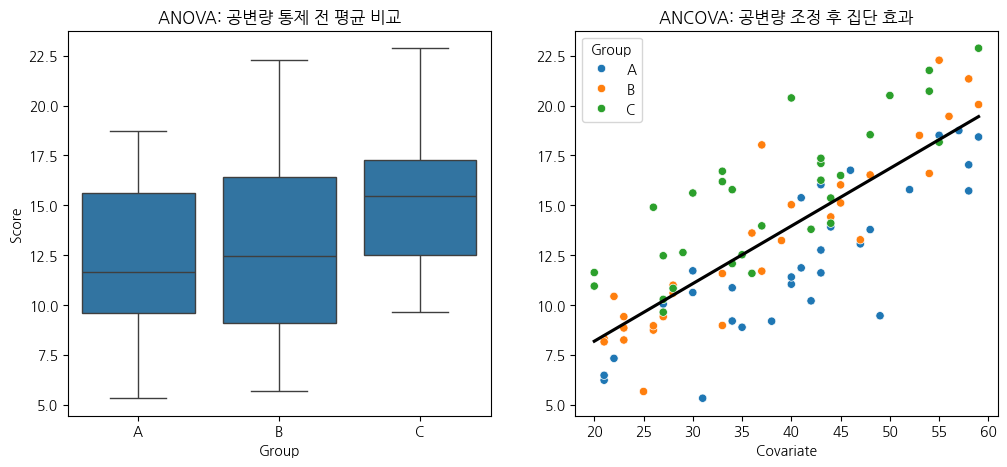

In [8]:
import seaborn as sns

plt.figure(figsize=(12,5))

# (1) 공변량 통제 전 단순 평균 비교
plt.subplot(1,2,1)
sns.boxplot(x="Group", y="Score", data=df)
plt.title("ANOVA: 공변량 통제 전 평균 비교")

# (2) 공변량에 따른 회귀선 (ANCOVA)
plt.subplot(1,2,2)
sns.scatterplot(x="Covariate", y="Score", hue="Group", data=df)
sns.regplot(x="Covariate", y=model_ancova.fittedvalues, data=df, scatter=False, ci=None, color="black")
plt.title("ANCOVA: 공변량 조정 후 집단 효과")
plt.show()

## 해석 흐름

 - ANOVA 결과 → 집단 간 평균 차이가 유의한가?

 - ANCOVA 결과 → 공변량(예: 나이)을 통제한 후에도 집단 차이가 남는가?

 - 그래프에서 → 박스플롯은 단순 평균 차이, 산점도+회귀선은 공변량 보정 후 효과를 보여줌.

# Part 3. 비모수 대안 (가정 위반 대비)

## 6. Mann–Whitney U Test (Wilcoxon Rank-Sum)

* 대상: 두 독립집단
* 대안: 독립표본 t-test
* 해석: 한 집단이 다른 집단보다 값이 클 확률





t-test 결과: t=-3.493, p=0.0009
Mann–Whitney U 결과: U=220.0, p=0.0007


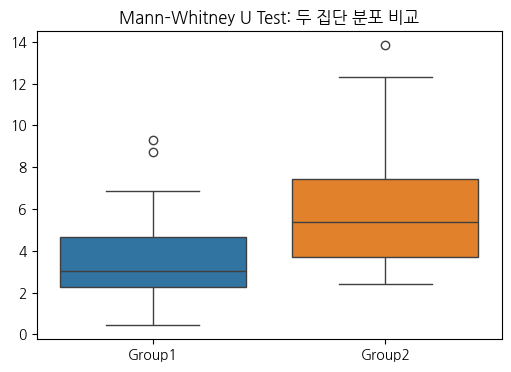

In [9]:
# Mann–Whitney U Test (독립 2집단)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind

np.random.seed(42)

# 두 집단 데이터 (정규성 위반하도록 비대칭 분포)
group1 = np.random.gamma(shape=2, scale=2, size=30)  # Gamma 분포
group2 = np.random.gamma(shape=2, scale=3, size=30)

# t-test (참고용)
t_stat, t_p = ttest_ind(group1, group2)
print(f"t-test 결과: t={t_stat:.3f}, p={t_p:.4f}")

# Mann–Whitney U test
u_stat, u_p = mannwhitneyu(group1, group2, alternative="two-sided")
print(f"Mann–Whitney U 결과: U={u_stat}, p={u_p:.4f}")

# 시각화
plt.figure(figsize=(6,4))
sns.boxplot(data=[group1, group2])
plt.xticks([0,1], ["Group1","Group2"])
plt.title("Mann–Whitney U Test: 두 집단 분포 비교")
plt.show()

## 7. Wilcoxon Signed-Rank Test

* 대상: 두 대응집단(짝 데이터)
* 대안: 대응표본 t-test
* 가정: 차이분포가 대칭적



대응표본 t-test: t=-1.199, p=0.2452
Wilcoxon Signed-Rank: W=83.0, p=0.4304


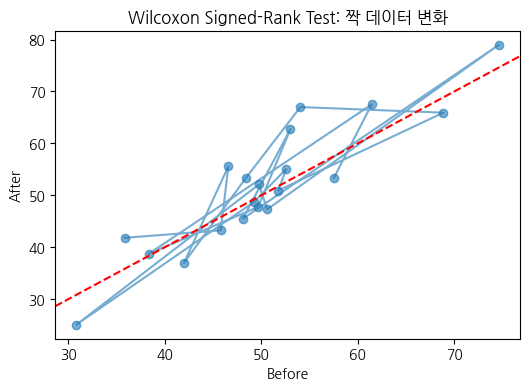

In [10]:
# Wilcoxon Signed-Rank Test (대응 2집단)
from scipy.stats import wilcoxon, ttest_rel

# 짝 데이터 (before-after 상황)
before = np.random.normal(50, 10, 20)
after  = before + np.random.normal(2, 5, 20)  # 개선 효과

# 대응표본 t-test
t_stat, t_p = ttest_rel(before, after)
print(f"대응표본 t-test: t={t_stat:.3f}, p={t_p:.4f}")

# Wilcoxon Signed-Rank Test
w_stat, w_p = wilcoxon(before, after)
print(f"Wilcoxon Signed-Rank: W={w_stat}, p={w_p:.4f}")

# 시각화
plt.figure(figsize=(6,4))
plt.plot(before, after, "o-", alpha=0.6)
plt.xlabel("Before"); plt.ylabel("After")
plt.title("Wilcoxon Signed-Rank Test: 짝 데이터 변화")
plt.axline((40,40), slope=1, color="red", linestyle="--")
plt.show()

## 8. 확장형 비모수

* Kruskal–Wallis: 일원 ANOVA 대안
* Friedman: 반복측정 ANOVA 대안

📌 정규성·등분산성 위반 → 비모수 검정”

📌 각 검정이 t-test/ANOVA의 대안임을 연결

ANOVA 결과: F=23.685, p=0.0000
Kruskal–Wallis 결과: H=25.402, p=0.0000


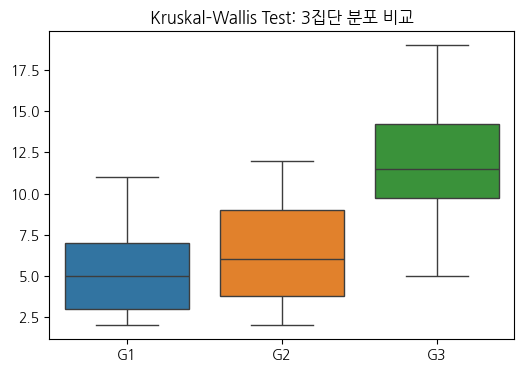

In [11]:
# Kruskal–Wallis (일원 ANOVA 대안)
from scipy.stats import kruskal, f_oneway

# 3집단 데이터 (정규성 위반, 서로 다른 분포)
g1 = np.random.poisson(5, 20)
g2 = np.random.poisson(7, 20)
g3 = np.random.poisson(10, 20)

# ANOVA (참고)
f_stat, f_p = f_oneway(g1, g2, g3)
print(f"ANOVA 결과: F={f_stat:.3f}, p={f_p:.4f}")

# Kruskal–Wallis Test
h_stat, h_p = kruskal(g1, g2, g3)
print(f"Kruskal–Wallis 결과: H={h_stat:.3f}, p={h_p:.4f}")

# 시각화
plt.figure(figsize=(6,4))
sns.boxplot(data=[g1, g2, g3])
plt.xticks([0,1,2], ["G1","G2","G3"])
plt.title("Kruskal–Wallis Test: 3집단 분포 비교")
plt.show()

Friedman Test: χ²=12.400, p=0.0020


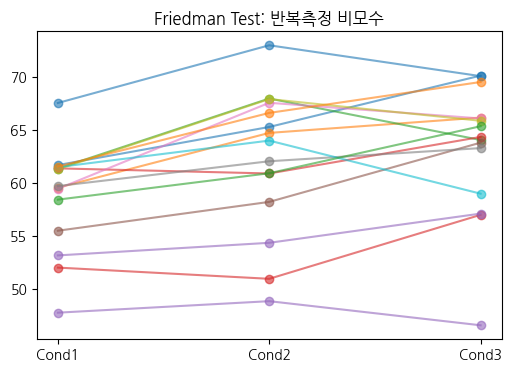

In [12]:
# Friedman Test (반복측정 ANOVA 대안)
from scipy.stats import friedmanchisquare

# 3조건 반복측정 데이터 (예: 같은 피험자 3조건 실험)
cond1 = np.random.normal(60, 5, 15)
cond2 = cond1 + np.random.normal(2, 3, 15)
cond3 = cond1 + np.random.normal(4, 3, 15)

# Friedman Test
fr_stat, fr_p = friedmanchisquare(cond1, cond2, cond3)
print(f"Friedman Test: χ²={fr_stat:.3f}, p={fr_p:.4f}")

# 시각화
plt.figure(figsize=(6,4))
plt.plot([1,2,3], np.vstack([cond1, cond2, cond3]), "o-", alpha=0.6)
plt.xticks([1,2,3], ["Cond1","Cond2","Cond3"])
plt.title("Friedman Test: 반복측정 비모수")
plt.show()

# Part 4. 카운트 자료 분석

## 9. 포아송 분석 (Poisson Regression)

* 목적: 사건 발생 횟수(count data) 모델링
* 링크함수: log
* 해석: exp(β)=IRR(발생률비)
* 문제점: 과산포(overdispersion) → 음이항 회귀(Negative Binomial)
* 오프셋(offset): 관측 시간·노출량 보정

📌 count data → 포아송/음이항

📌 IRR 해석 “exp(β)=1.3 → 30% 증가”


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -388.70
Date:                Mon, 29 Sep 2025   Deviance:                       227.14
Time:                        11:49:59   Pearson chi2:                     208.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7109
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0261      0.060     -0.433      0.6

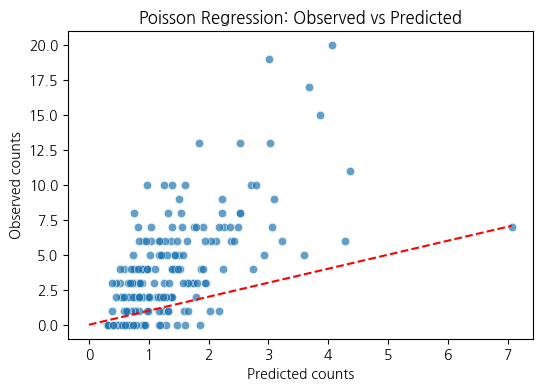

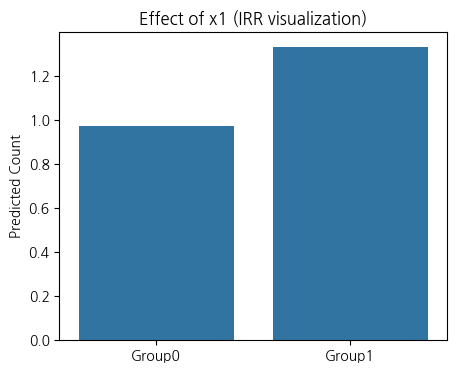

In [13]:
# Poisson Regression
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# -----------------------------
# 1. 가짜 데이터 생성
# -----------------------------
n = 200
exposure = np.random.uniform(1, 5, size=n)   # 노출시간(오프셋)
x1 = np.random.binomial(1, 0.5, n)           # 범주형 (예: 그룹 A/B)
x2 = np.random.normal(0, 1, n)               # 연속형 (예: 나이 표준화)

# Poisson 모델로 사건 발생 횟수 생성
lam = np.exp(0.3*x1 + 0.5*x2 + np.log(exposure))
y = np.random.poisson(lam)

df = pd.DataFrame({"count": y, "x1": x1, "x2": x2, "exposure": exposure})

# -----------------------------
# 2. Poisson 회귀 적합
# -----------------------------
model = smf.glm(
    formula="count ~ x1 + x2",
    data=df,
    family=sm.families.Poisson(),
    offset=np.log(df["exposure"])
).fit()

print(model.summary())

# -----------------------------
# 3. IRR (Incident Rate Ratio) 계산
# -----------------------------
params = model.params
irr = np.exp(params)
print("\nIncident Rate Ratios (IRR):")
print(irr)

# -----------------------------
# 4. 시각화: 예측값 vs 관측값
# -----------------------------
df["pred"] = model.predict(df)

plt.figure(figsize=(6,4))
sns.scatterplot(x=df["pred"], y=df["count"], alpha=0.7)
plt.plot([0, max(df["pred"])], [0, max(df["pred"])], "r--")
plt.xlabel("Predicted counts")
plt.ylabel("Observed counts")
plt.title("Poisson Regression: Observed vs Predicted")
plt.show()

# -----------------------------
# 5. 시각화: 그룹별 IRR 효과
# -----------------------------
mean_x2 = df["x2"].mean()
new_data = pd.DataFrame({
    "x1": [0,1],
    "x2": [mean_x2, mean_x2],
    "exposure": [1,1]
})
new_data["pred"] = model.predict(new_data)

plt.figure(figsize=(5,4))
sns.barplot(x=["Group0","Group1"], y=new_data["pred"])
plt.title("Effect of x1 (IRR visualization)")
plt.ylabel("Predicted Count")
plt.show()

📊 결과 해석

model.summary() → 계수(β) 확인

np.exp(β) = IRR

예: IRR=1.3 → 사건 발생률이 30% 증가

예: IRR=0.8 → 사건 발생률이 20% 감소

오프셋(log(exposure))을 넣었기 때문에, 노출시간 보정된 발생률로 해석 가능

# PART 5. 공통 심화 주제

## 10. 검정력 & 표본수 (Power Analysis)

* 정의: 1−β (참 효과 있을 때 발견할 확률)
* 영향 요인: 효과크기, 표본수, α, 변동성
* 목표: 보통 0.8 이상

## 11. 다중비교 보정

* FWER 제어: Bonferroni, Holm, Tukey
* FDR 제어: Benjamini–Hochberg
    

## 질문:왜 보정하나

* 가설이 m개일 때 그대로 α=0.05를 쓰면, “우연히라도 유의”가 하나쯤 나올 확률이 급증
* FWER(Family-Wise Error Rate): 한 번이라도(≥1개) 틀리게 기각할 확률 P(V≥1) ≤ α 로 제어
* FDR(False Discovery Rate): 기각한 것들 중 거짓 기각의 비율의 기댓값 E(V/R) ≤ q 로 제어



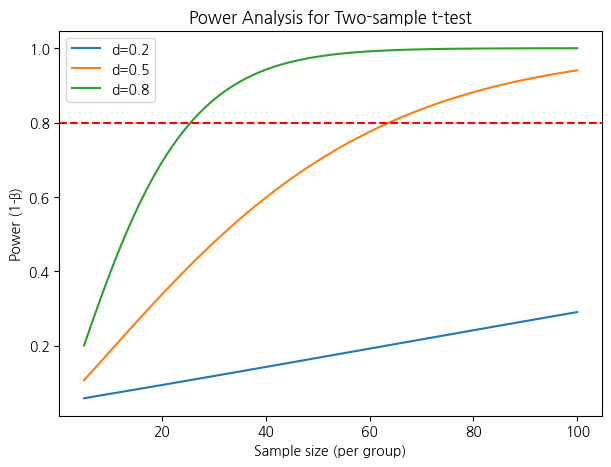

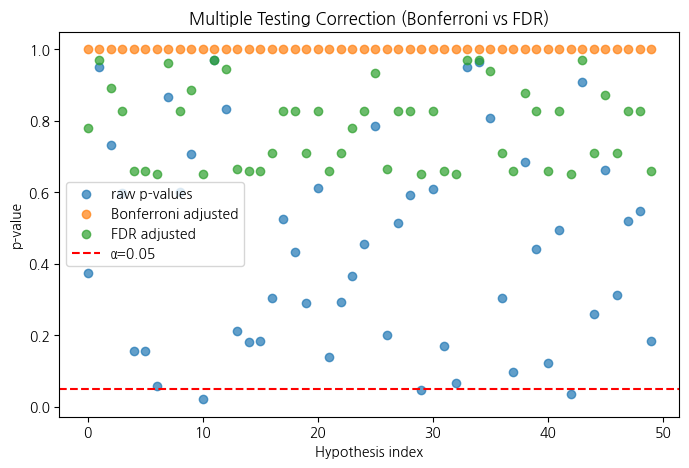

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm

# -----------------------------
# 10. 검정력 분석 (Power Analysis)
# -----------------------------
analysis = TTestIndPower()

# 효과크기 (Cohen's d), 표본수(n), 유의수준(alpha)에 따른 power 곡선
effect_sizes = [0.2, 0.5, 0.8]  # small, medium, large
sample_sizes = np.arange(5, 101)

plt.figure(figsize=(7,5))
for d in effect_sizes:
    power = analysis.power(effect_size=d, nobs1=sample_sizes, alpha=0.05)
    plt.plot(sample_sizes, power, label=f"d={d}")
plt.axhline(0.8, color="red", linestyle="--")
plt.xlabel("Sample size (per group)")
plt.ylabel("Power (1-β)")
plt.title("Power Analysis for Two-sample t-test")
plt.legend()
plt.show()

# -----------------------------
# 11. 다중비교 보정
# -----------------------------
np.random.seed(42)
m = 50   # 50개의 가설 검정
alpha = 0.05

# 귀무가설이 참인 경우 p-value는 균일분포(0~1)
p_values = np.random.rand(m)

# Bonferroni & FDR 보정
reject_bonf, p_bonf, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
reject_fdr, p_fdr, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# 시각화: 원본 vs 보정 p-value
plt.figure(figsize=(8,5))
plt.scatter(range(m), p_values, label="raw p-values", alpha=0.7)
plt.scatter(range(m), p_bonf, label="Bonferroni adjusted", alpha=0.7)
plt.scatter(range(m), p_fdr, label="FDR adjusted", alpha=0.7)
plt.axhline(alpha, color="red", linestyle="--", label="α=0.05")
plt.xlabel("Hypothesis index")
plt.ylabel("p-value")
plt.title("Multiple Testing Correction (Bonferroni vs FDR)")
plt.legend()
plt.show()


🔹 Power Analysis

효과크기 클수록, 표본수 많을수록, α(유의수준) 클수록 → 검정력 ↑

보통 0.8 이상을 목표로 한다.
→ 예: d=0.5 (중간 효과), n≈30명 이상이면 Power ≈ 0.8 도달

🔹 다중비교 보정

원래 p-value는 대체로 균일하게 퍼져 있음

Bonferroni: 아주 보수적 → 거의 유의하지 않게 됨

FDR(BH): 좀 더 유연 → 탐색 연구에서 자주 사용

Without correction: 46 false positives out of 1000
With Bonferroni:    0 false positives
With FDR:           0 false positives


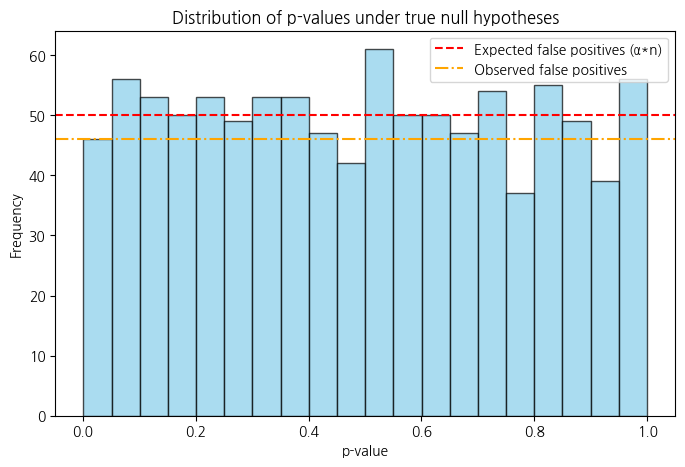

In [15]:
# 보너스 스테이지: 다중검정 시뮬레이션
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

np.random.seed(123)

# -----------------------------
# 시뮬레이션 설정
# -----------------------------
n_tests = 1000   # 가설 개수
n_samples = 30   # 각 집단 샘플 수
alpha = 0.05

# 귀무가설이 참이라고 가정 → 평균이 동일한 정규분포에서 데이터 생성
group1 = np.random.normal(0, 1, (n_tests, n_samples))
group2 = np.random.normal(0, 1, (n_tests, n_samples))

# 각 테스트별 p-value 계산
p_values = np.array([ttest_ind(group1[i], group2[i])[1] for i in range(n_tests)])

# -----------------------------
# 보정 없는 경우
# -----------------------------
false_positives_raw = np.sum(p_values < alpha)

# -----------------------------
# 보정한 경우 (Bonferroni, FDR)
# -----------------------------
reject_bonf, _, _, _ = multipletests(p_values, alpha=alpha, method="bonferroni")
reject_fdr, _, _, _ = multipletests(p_values, alpha=alpha, method="fdr_bh")

false_positives_bonf = np.sum(reject_bonf)
false_positives_fdr = np.sum(reject_fdr)

print(f"Without correction: {false_positives_raw} false positives out of {n_tests}")
print(f"With Bonferroni:    {false_positives_bonf} false positives")
print(f"With FDR:           {false_positives_fdr} false positives")

# -----------------------------
# 시각화
# -----------------------------
plt.figure(figsize=(8,5))
plt.hist(p_values, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
plt.axhline(y=alpha*n_tests, color="red", linestyle="--", label="Expected false positives (α*n)")
plt.axhline(y=false_positives_raw, color="orange", linestyle="-.", label="Observed false positives")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values under true null hypotheses")
plt.legend()
plt.show()


📊 해석

보정 안 함 (raw): 1000개 중 약 50개 정도는 그냥 우연히 p<0.05 나옴 → 즉, 가짜 양성(False Positive).

Bonferroni: 매우 보수적이라 거의 0개만 남음. (대신 진짜 효과도 놓칠 수 있음)

FDR: 어느 정도 잡아주면서도 탐색적 발견은 허용 → 연구 초기에 자주 쓰임.